In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, MinMaxScaler, StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import matplotlib.patches as mp

## Breast Cancer Dataset

In [3]:
breast_cancer_dataset = load_breast_cancer()
df_breast_cancer = pd.DataFrame().from_dict(breast_cancer_dataset['data'])
df_breast_cancer.columns = breast_cancer_dataset['feature_names']
df_breast_cancer

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### 2 - b) Distribuição das Features em Bin Fixos
Features: Mean radius e Mean Perimeter

In [4]:
n_bins = 3
bins = dict()
df_breast_cancer_bins = pd.DataFrame()
for feature in ['mean radius', 'mean perimeter']:
    feat_max_value = df_breast_cancer[feature].max()
    feat_min_value = df_breast_cancer[feature].min()
    tamanho_bin = (feat_max_value - feat_min_value) / n_bins
    valores_bin = [feat_min_value, feat_max_value]
    for n in range(1, n_bins):
        valores_bin.insert(1, valores_bin[len(valores_bin)-n] - tamanho_bin)
    bins[feature] = valores_bin
    df_breast_cancer_bins[feature] = pd.cut(df_breast_cancer[feature], bins=bins[feature], include_lowest=True, labels=False)
    print(df_breast_cancer_bins[feature].value_counts())

mean radius
0    338
1    209
2     22
Name: count, dtype: int64
mean perimeter
0    343
1    204
2     22
Name: count, dtype: int64


### 2 - c) Distribuição das Features em Bin Variáveis
Features: Mean radius e Mean Perimeter

In [5]:
n_quantiles = 3
percentil = f"{(100 / n_quantiles):.2f}%"
df_breast_cancer_bins_variaveis = pd.DataFrame()

for feature in ['mean radius', 'mean perimeter']:
    labels = [percentil + " Menores", percentil + " Médios", percentil + " Maiores"]
    df_breast_cancer_bins_variaveis[feature] = pd.qcut(df_breast_cancer[feature], q=n_quantiles, labels=labels)
    print(df_breast_cancer_bins_variaveis[feature].value_counts())
    

mean radius
33.33% Menores    191
33.33% Maiores    190
33.33% Médios     188
Name: count, dtype: int64
mean perimeter
33.33% Menores    190
33.33% Maiores    190
33.33% Médios     189
Name: count, dtype: int64


### 3 - a) Uso da Função FunctionTransformer do sklearn no Breast Cancer Dataset
Função Max Min Scaler

In [ ]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

df_breast_cancer_min_max = FunctionTransformer(min_max_scaler).fit_transform(df_breast_cancer)
df_breast_cancer_min_max

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056,...,0.623266,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
565,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100,...,0.560655,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
566,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321,...,0.393099,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909
567,0.644564,0.663510,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442,...,0.633582,0.730277,0.668310,0.402035,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315


### 3 - b) Uso da Função PowerTransformer do sklearn no Breast Cancer Dataset

In [10]:
powerTransformer = PowerTransformer()
X_breast_cancer_power = powerTransformer.fit_transform(df_breast_cancer)
df_breast_cancer_power = pd.DataFrame(X_breast_cancer_power, columns=powerTransformer.get_feature_names_out())
df_breast_cancer_power


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.134881,-2.678666,1.259822,1.126421,1.504114,2.165938,1.862988,1.848558,1.953067,1.886398,...,1.619635,-1.488367,1.810506,1.652210,1.282792,1.942737,1.730182,1.935654,2.197206,1.723624
1,1.619346,-0.264377,1.528723,1.633946,-0.820227,-0.384102,0.291976,0.820609,0.102291,-0.956577,...,1.578689,-0.288382,1.430616,1.610022,-0.325080,-0.296580,0.070746,1.101594,-0.121997,0.537179
2,1.464796,0.547806,1.454664,1.461645,0.963977,1.163977,1.403673,1.683104,0.985668,-0.292433,...,1.419757,0.071406,1.321941,1.425307,0.580301,1.209701,1.005512,1.722744,1.218181,0.453955
3,-0.759262,0.357721,-0.514886,-0.836238,2.781494,2.197843,1.642391,1.423004,2.360528,2.708925,...,-0.083692,0.228089,-0.039480,-0.436860,2.857821,2.282276,1.675087,1.862378,3.250202,2.517606
4,1.571260,-1.233520,1.583340,1.595120,0.343932,0.762392,1.407479,1.410929,0.090964,-0.511332,...,1.293727,-1.637882,1.316582,1.309486,0.284367,-0.131829,0.817474,0.807077,-0.943554,-0.279402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.781795,0.785604,1.746492,1.823030,1.052829,0.460810,1.653784,1.783067,-0.232645,-1.053698,...,1.626869,0.212151,1.547961,1.657442,0.438013,-0.077871,0.859079,1.503734,-1.721528,-0.751459
565,1.543335,1.845150,1.485601,1.545430,0.168014,0.207602,0.984746,1.320730,-0.129120,-1.259564,...,1.433823,1.832201,1.365939,1.443167,-0.667317,-0.245277,0.480804,0.810995,-0.480093,-1.210527
566,0.828589,1.817618,0.811329,0.835270,-0.835509,0.183969,0.375105,0.396882,-0.808189,-0.998237,...,0.769202,1.320625,0.786129,0.796192,-0.799337,0.626487,0.566826,0.526136,-1.301164,-0.170872
567,1.624440,2.016299,1.702747,1.551036,1.468642,2.162820,1.994466,1.884414,1.899087,1.147810,...,1.656477,1.968949,1.810506,1.513198,1.387135,2.284642,2.136932,1.931990,1.744693,1.850944


### 4 - a) Uso da Função MinMaxScaler do sklearn no Breast Cancer Dataset

In [13]:
scaler = MinMaxScaler()
x_breast_cancer_min_max_scale = scaler.fit_transform(df_breast_cancer)
df_breast_cancer_min_max_scale = pd.DataFrame(x_breast_cancer_min_max_scale, columns=scaler.get_feature_names_out())
df_breast_cancer_min_max_scale

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056,...,0.623266,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
565,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100,...,0.560655,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
566,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321,...,0.393099,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909
567,0.644564,0.663510,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442,...,0.633582,0.730277,0.668310,0.402035,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315


### 4 - b) Uso da Função StandardScaler do sklearn no Breast Cancer Dataset

In [14]:
scaler = StandardScaler()
x_breast_cancer_standard_scale = scaler.fit_transform(df_breast_cancer)
df_breast_cancer_standard_scale = pd.DataFrame(x_breast_cancer_standard_scale, columns=scaler.get_feature_names_out())
df_breast_cancer_standard_scale

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091
565,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635


### 4 - c) Uso da Função Nomalizer do sklearn no Breast Cancer Dataset

In [15]:
normalizer = Normalizer('l2')
x_breast_cancer_nomal_l2 = normalizer.fit_transform(df_breast_cancer)
df_breast_cancer_normal_l2 = pd.DataFrame(x_breast_cancer_nomal_l2, columns=scaler.get_feature_names_out())
df_breast_cancer_normal_l2

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.007925,0.004573,0.054099,0.440986,0.000052,0.000122,0.000132,0.000065,0.000107,0.000035,...,0.011181,0.007635,0.081325,0.889462,0.000071,0.000293,0.000314,0.000117,0.000203,0.000052
1,0.008666,0.007486,0.055988,0.558619,0.000036,0.000033,0.000037,0.000030,0.000076,0.000024,...,0.010528,0.009862,0.066899,0.824026,0.000052,0.000079,0.000102,0.000078,0.000116,0.000038
2,0.009367,0.010109,0.061842,0.572276,0.000052,0.000076,0.000094,0.000061,0.000098,0.000029,...,0.011212,0.012145,0.072545,0.812984,0.000069,0.000202,0.000214,0.000116,0.000172,0.000042
3,0.016325,0.029133,0.110899,0.551922,0.000204,0.000406,0.000345,0.000150,0.000371,0.000139,...,0.021314,0.037881,0.141333,0.811515,0.000300,0.001238,0.000982,0.000368,0.000949,0.000247
4,0.009883,0.006985,0.065808,0.631774,0.000049,0.000065,0.000096,0.000051,0.000088,0.000029,...,0.010979,0.008120,0.074137,0.767189,0.000067,0.000100,0.000195,0.000079,0.000115,0.000037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.008541,0.008870,0.056256,0.585933,0.000044,0.000046,0.000097,0.000055,0.000068,0.000022,...,0.010082,0.010459,0.065804,0.803033,0.000056,0.000084,0.000163,0.000088,0.000082,0.000028
565,0.009344,0.013114,0.060903,0.585355,0.000045,0.000048,0.000067,0.000045,0.000081,0.000026,...,0.010997,0.017756,0.071951,0.803528,0.000054,0.000089,0.000149,0.000076,0.000119,0.000031
566,0.011644,0.019696,0.075966,0.601905,0.000059,0.000072,0.000065,0.000037,0.000112,0.000040,...,0.013313,0.023933,0.088872,0.788417,0.000080,0.000217,0.000239,0.000099,0.000156,0.000055
567,0.009230,0.013142,0.062774,0.566806,0.000053,0.000124,0.000157,0.000068,0.000107,0.000031,...,0.011533,0.017663,0.082713,0.815932,0.000074,0.000389,0.000421,0.000119,0.000183,0.000056


## Carregando o Large Movie Review Dataset

In [28]:
path_raiz = os.getcwd()
path_treino = os.path.join(path_raiz ,"aclImdb/train")
path_teste = os.path.join(path_raiz ,"aclImdb/test")
def carregar_imdb(path):
    reviews = []
    targets = []
    pasta_pos = os.path.join(path, 'pos')
    pasta_neg = os.path.join(path, 'neg')
    for path_arquivo in os.listdir(pasta_pos):
        if path_arquivo.endswith('.txt'):
            with open(os.path.join(pasta_pos, path_arquivo), 'r', encoding='utf-8') as arquivo:
                reviews.append(arquivo.read())
                targets.append(1)
                arquivo.close()
    for path_arquivo in os.listdir(pasta_neg):
        if path_arquivo.endswith('.txt'):
            with open(os.path.join(pasta_neg, path_arquivo), 'r', encoding='utf-8') as arquivo:
                reviews.append(arquivo.read())
                targets.append(0)
                arquivo.close()

    return pd.DataFrame({'review': reviews, 'target': targets})

df_treino_lmr = carregar_imdb(path_treino)
df_teste_lmr = carregar_imdb(path_teste)
df_lmr = pd.concat([df_treino_lmr, df_teste_lmr], ignore_index=True)
df_lmr

,review,target
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
...,...,...
49995,I occasionally let my kids watch this garbage ...,0
49996,When all we have anymore is pretty much realit...,0
49997,The basic genre is a thriller intercut with an...,0
49998,Four things intrigued me as to this film - fir...,0


## 5 - a) Aplicando Algorítimo de remoção de Stopwords

In [29]:
stop_words = set(stopwords.words('english'))
lista_lmr_stop_words = []
for texto in df_lmr['review']:
    palavras = texto.split()  
    texto_sem_stopwords = " ".join([palavra for palavra in palavras if palavra.lower() not in stop_words])
    lista_lmr_stop_words.append(texto_sem_stopwords)
df_lmr_stopword = pd.DataFrame(lista_lmr_stop_words, columns=['review'])
df_lmr_stopword

,review
0,Bromwell High cartoon comedy. ran time program...
1,Homelessness (or Houselessness George Carlin s...
2,Brilliant over-acting Lesley Ann Warren. Best ...
3,easily underrated film inn Brooks cannon. Sure...
4,typical Mel Brooks film. much less slapstick m...
...,...
49995,occasionally let kids watch garbage understand...
49996,anymore pretty much reality TV shows people ma...
49997,basic genre thriller intercut uncomfortable me...
49998,"Four things intrigued film - firstly, stars Ca..."


### 5 - b) Aplicando a Função Stemming ao set de Stopwords do Large Movies Reviews

In [30]:
stemmer = PorterStemmer()

lista_lmr_stem = []
for texto in df_lmr_stopword['review']:
    lista_lmr_stem.append(' '.join([stemmer.stem(palavra) for palavra in texto.split()]))

df_lmr_stem = pd.DataFrame(lista_lmr_stem, columns=['review'])
df_lmr_stem

,review
0,bromwel high cartoon comedy. ran time program ...
1,homeless (or houseless georg carlin stated) is...
2,brilliant over-act lesley ann warren. best dra...
3,"easili underr film inn brook cannon. sure, fla..."
4,typic mel brook film. much less slapstick movi...
...,...
49995,occasion let kid watch garbag understand pathe...
49996,anymor pretti much realiti tv show peopl make ...
49997,basic genr thriller intercut uncomfort menage-...
49998,"four thing intrigu film - firstly, star carli ..."


### 5 - c) Aplicando a Função Lemmatization ao set de Stopwords do Large Movies Reviews

In [31]:
wnl = WordNetLemmatizer()  

lista_lmr_lemme = []
for texto in df_lmr['review']:
    texto_lemme = " ".join([wnl.lemmatize(word) for word in texto.split()])
    lista_lmr_lemme.append(texto_lemme)

df_lmr_lemme = pd.DataFrame(lista_lmr_lemme, columns=['review'])
df_lmr_lemme

,review
0,Bromwell High is a cartoon comedy. It ran at t...
1,Homelessness (or Houselessness a George Carlin...
2,Brilliant over-acting by Lesley Ann Warren. Be...
3,This is easily the most underrated film inn th...
4,This is not the typical Mel Brooks film. It wa...
...,...
49995,I occasionally let my kid watch this garbage s...
49996,When all we have anymore is pretty much realit...
49997,The basic genre is a thriller intercut with an...
49998,Four thing intrigued me a to this film - first...


### 5 - d) Aplicando a Função CountVectorizer para BoW ao set de stem do Large Movies Reviews

In [32]:
bow = CountVectorizer(max_features=8000, dtype=np.int32)
bow_lmr_stem = bow.fit_transform(df_lmr_stem['review'])
df_bow_lrm = pd.DataFrame(bow_lmr_stem.toarray(), columns=bow.get_feature_names_out())
df_bow_lrm

,00,000,007,10,100,1000,101,11,12,13,...,zeta,zhang,zizek,zoey,zombi,zombie,zombies,zone,zoom,zorro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


5 - e) Aplicando a Função CountVectorizer para Bigrams para BoW ao set de lemmes do Large Movies Reviews

In [33]:
bow = CountVectorizer(max_features=8000, ngram_range=(2,2), dtype=np.int32)
bow_lmr_lemme = bow.fit_transform(df_lmr_lemme['review'])
df_bow_lrm = pd.DataFrame(bow_lmr_lemme.toarray(), columns=bow.get_feature_names_out())
df_bow_lrm

,10 10,10 and,10 br,10 for,10 minute,10 out,10 year,12 year,15 minute,15 year,...,your face,your head,your heart,your life,your mind,your money,your own,your seat,your time,yourself favor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6 - a) Aplicando a função TfidfVectorizer no dataset Large Movie Review

In [34]:
tfidf = TfidfVectorizer(max_features=8000, dtype=np.float32)
df_tfidf_lmr = tfidf.fit_transform(df_lmr['review'])
df_tfidf_lmr = pd.DataFrame(df_tfidf_lmr.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf_lmr

,00,000,10,100,1000,101,11,12,13,13th,...,zane,zany,zellweger,zero,zeta,zizek,zoey,zombie,zombies,zone
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.04682,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6 - b) Modelo de Regressão Logística utilizando TF-IDF

In [38]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(df_tfidf_lmr, df_lmr['target'], test_size=0.4, random_state=7)

modelo = LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced')
modelo.fit(X_treino, Y_treino)

y_pred = modelo.predict(X_teste)

print(f"Acurácia: {(100 * accuracy_score(Y_teste, y_pred)):.2f}%")
print(f"Precisão: {(100 * precision_score(Y_teste, y_pred)):.2f}%")
print(f"Recall: {(100 * recall_score(Y_teste, y_pred)):.2f}%")
print(f"F1-Score: {(100 * f1_score(Y_teste, y_pred)):.2f}%")

Acurácia: 88.97%
Precisão: 87.96%
Recall: 89.97%
F1-Score: 88.95%


## Carregando o Dataset Powerlifting

In [16]:
df_powerlifting = pd.read_csv('openpowerlifting.csv')
df_powerlifting 

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,Angie Belk Terry,F,Wraps,47.0,Mst 45-49,59.60,60,NaN,47.63,NaN,20.41,NaN,70.31,138.35,1,155.05
1,0,Dawn Bogart,F,Single-ply,42.0,Mst 40-44,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
2,0,Dawn Bogart,F,Single-ply,42.0,Open Senior,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
3,0,Dawn Bogart,F,Raw,42.0,Open Senior,58.51,60,NaN,NaN,NaN,95.25,NaN,NaN,95.25,1,108.29
4,0,Destiny Dula,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,NaN,NaN,31.75,NaN,90.72,122.47,1,130.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386409,8481,William Barabas,M,Multi-ply,NaN,Elite,113.58,125,NaN,NaN,NaN,NaN,NaN,347.50,347.50,2,202.60
386410,8481,Justin Zottl,M,Multi-ply,NaN,Elite,119.02,125,NaN,NaN,NaN,NaN,NaN,322.50,322.50,3,185.77
386411,8481,Jake Anderson,M,Multi-ply,NaN,Elite,120.29,125,NaN,NaN,NaN,NaN,NaN,367.50,367.50,1,211.17
386412,8481,Jeff Bumanglag,M,Multi-ply,NaN,Elite,126.73,140,NaN,NaN,NaN,NaN,NaN,320.00,320.00,3,181.85


## 7 - a) Aplicando o OneHotEncoding ao dataset Powerlifting

In [17]:
onehot_encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=np.int8)
categorias_col = ['Sex', 'Equipment']
df_pwrlft_onehot = onehot_encoder.fit_transform(df_powerlifting[categorias_col])
df_pwrlft_onehot = pd.DataFrame(df_pwrlft_onehot, columns=onehot_encoder.get_feature_names_out())
df_pwrlft_onehot

,Sex_F,Sex_M,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Straps,Equipment_Wraps
0,1,0,0,0,0,0,1
1,1,0,0,0,1,0,0
2,1,0,0,0,1,0,0
3,1,0,0,1,0,0,0
4,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...
386409,0,1,1,0,0,0,0
386410,0,1,1,0,0,0,0
386411,0,1,1,0,0,0,0
386412,0,1,1,0,0,0,0


## 7 - b) Aplicando o DummyEncoding ao dataset Powerlifting

In [18]:
categorias_col = ['Sex', 'Equipment']
dummy_encoder = OneHotEncoder(sparse_output=False, drop='first' , dtype=np.int8)
pwrlft_dummy = dummy_encoder.fit_transform(df_powerlifting[categorias_col])
df_pwrlft_dummy = pd.DataFrame(pwrlft_dummy, columns=dummy_encoder.get_feature_names_out())
df_pwrlft_dummy

,Sex_M,Equipment_Raw,Equipment_Single-ply,Equipment_Straps,Equipment_Wraps
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
386409,1,0,0,0,0
386410,1,0,0,0,0
386411,1,0,0,0,0
386412,1,0,0,0,0


## 7 - c) Aplicando o EffectEncoding ao dataset Powerlifting

In [20]:
effect_encoded = pwrlft_dummy.copy()

for i, col in enumerate(categorias_col):
    # Encontrar índices da categoria de referência
    ref_category_idx = dummy_encoder.drop_idx_[i]
    ref_category = onehot_encoder.categories_[i][ref_category_idx]
    
    # Identificar linhas com categoria de referência
    ref_mask = (df_powerlifting[col] == ref_category)
    
    # Substituir 0 por -1 nas colunas da variável atual
    start_idx = sum(len(onehot_encoder.categories_[j]) - 1 for j in range(i))
    end_idx = start_idx + len(onehot_encoder.categories_[i]) - 1
    effect_encoded[ref_mask, start_idx:end_idx] = -1

df_pwrlft_effect = pd.DataFrame(effect_encoded, columns=dummy_encoder.get_feature_names_out())
df_pwrlft_effect

,Sex_M,Equipment_Raw,Equipment_Single-ply,Equipment_Straps,Equipment_Wraps
0,-1,0,0,0,1
1,-1,0,1,0,0
2,-1,0,1,0,0
3,-1,1,0,0,0
4,-1,1,0,0,0
...,...,...,...,...,...
386409,1,-1,-1,-1,-1
386410,1,-1,-1,-1,-1
386411,1,-1,-1,-1,-1
386412,1,-1,-1,-1,-1


### 8 - a) i. Aplicação do Feature Hashing ao Powerlifting dataset

In [118]:
categorical_cols = ['Sex', 'Equipment']

df_hashs = []
for col in categorias_col:
    n = df_powerlifting[[col]].value_counts().count()
    hasher = FeatureHasher(n_features=n, input_type='string')
    pwrlft_hashed = hasher.fit_transform(df_powerlifting[[col]].values)
    df_hashs.append(pd.DataFrame(pwrlft_hashed.toarray(), columns=[f"Hash_{col}_{i}" for i in range(n)]))
df_pwrlft_hashed = pd.concat(df_hashs, axis=1)
df_pwrlft_hashed

,Hash_Sex_0,Hash_Sex_1,Hash_Equipment_0,Hash_Equipment_1,Hash_Equipment_2,Hash_Equipment_3,Hash_Equipment_4
0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0
2,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0
3,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...
386409,1.0,0.0,0.0,0.0,-1.0,0.0,0.0
386410,1.0,0.0,0.0,0.0,-1.0,0.0,0.0
386411,1.0,0.0,0.0,0.0,-1.0,0.0,0.0
386412,1.0,0.0,0.0,0.0,-1.0,0.0,0.0


# Carregando o Lung Cancer Dataset

In [119]:
df_lung_cancer = pd.read_csv('Lung Cancer Dataset.csv')
df_lung_cancer 

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,0,1,1,0,0,1,60.700696,1,1,1,1,94.012495,0,1,1,0,YES
4996,80,0,1,1,1,1,1,50.751741,0,1,1,1,94.394968,0,0,0,0,YES
4997,51,1,0,0,1,0,0,61.063496,1,0,0,0,98.108901,0,0,0,1,NO
4998,76,1,0,1,0,0,0,48.662872,0,1,0,1,95.577773,1,0,0,0,NO


### 10 - a) Aplicação do PCA no Lung Cancer Dataset

C:\Users\josem\AppData\Local\Temp\ipykernel_12448\330922090.py:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(('YES', 'NO'),'best')


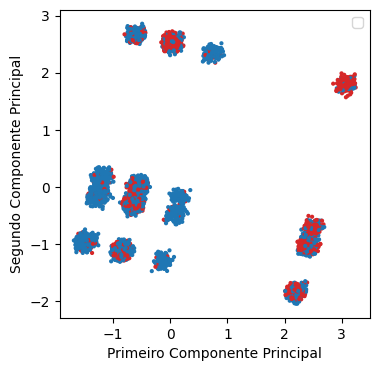

In [188]:
scaler = StandardScaler()
lung_cancer_scaled = scaler.fit_transform(df_lung_cancer.drop('PULMONARY_DISEASE', axis=1))
pca = PCA(n_components=2)
lung_cancer_pca = pca.fit_transform(lung_cancer_scaled)
df_lung_cancer_pca = pd.DataFrame(lung_cancer_pca, columns=pca.get_feature_names_out())
plt.figure(figsize=(4,4))
plt.scatter(df_lung_cancer_pca['pca0'], df_lung_cancer_pca['pca1'], s=4, c=df_lung_cancer['PULMONARY_DISEASE'].apply(lambda x: 'tab:red' if x == 'YES' else 'tab:blue'))
plt.legend(('YES', 'NO'),'best')
plt.xlabel("Primeiro Componente Principal")
plt.ylabel("Segundo Componente Principal")
plt.show()